In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.express as px

import cufflinks as cf
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

In [2]:
cf.set_config_file(theme='polar')

## Part 1 ‑  Exploratory data analysis  

The    attached       logins.json       file     contains     (simulated)     timestamps    of    user     logins     in    a    particular  geographic     location.     Aggregate     these     login     counts    based    on    15­ minute     time     intervals,    and  visualize     and    describe     the     resulting     time     series    of     login     counts     in    ways     that    best     characterize     the  underlying    patterns     of     the    demand.     Please     report/illustrate     important     features    of     the    demand,  such     as    daily     cycles.     If     there     are     data     quality     issues,    please     report     them. 


In [3]:
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
df.tail()

,login_time
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38
93141,1970-04-13 18:54:23


In [5]:
df.isnull().sum()

login_time    0
dtype: int64

Our data consists of logins between January 1st and April 13th 1970. There does not appear to be any missing data. That being said, we don't have data for the entire month of April, so I will focus only on the months of January through March. 

In [6]:
df['login_time'] = pd.to_datetime(df.login_time)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [7]:
df.set_index('login_time', inplace=True)
df['login_count'] = 1

In [8]:
resampledf_min = df.resample('15min').sum()

In [9]:
resampledf_min.iplot(kind='line', title='15 Minute Intervals')

Looking at the data resampled in 15 minute intervals, it is clear that there is a pattern in login times, though it is hard to tell exactly what that pattern is just from this plot. If I had to guess at this point, it looks as if each day has a certain time where the logins spike, and each week has a period of higher use. 

In [10]:
resampledf_hr = df.resample('H').sum()

In [11]:
resampledf_hr.iplot(kind='line', title='Hourly Intervals')

Looking at the data resampled hourly is similar to the 15 minute intervals. We'll try daily next.

In [12]:
resampledf_day = df.resample('D').sum()

In [13]:
resampledf_day.iplot(kind='line', title='Daily Intervals')

When resampled by day, we can clearly see a peaks in usage 7 days apart. Next we'll take a look at exclusively the month of March.

In [14]:
resampledf_min['1970-03-01':'1970-03-31'].iplot(kind='line', title='Month of March')

In [15]:
print(resampledf_min['1970-03-01'].index.dayofweek[0],resampledf_min['1970-03-08'].index.dayofweek[0])

6 6


Looking at logins on a monthly scale, we can see that there are generally two peak time periods per day. One occurs between approximately 11:00 - 1:00, and the other occurs at night between 21:00 and 23:00. There are further spikes in usage on weekend afternoons. 

In [16]:
resampledf_min['1970-03-01':'1970-03-7'].iplot(kind='line', title='March 1-7')

Viewing the data from the week of March 1st further shows the trend of one lunchtime and one nighttime peak per weekday. March 1st and 7th are a Saturday and a Friday, showing again that weekends have the highest login counts. 

In [17]:
resampledf_min['month'] = resampledf_min.index.month
resampledf_min['week'] = resampledf_min.index.week
resampledf_min['day'] = resampledf_min.index.day
resampledf_min['day_of_week'] = resampledf_min.index.dayofweek
resampledf_min['hour'] = resampledf_min.index.hour
resampledf_min.head()

,login_count,month,week,day,day_of_week,hour
login_time,,,,,,
1970-01-01 20:00:00,2,1,1,1,3,20
1970-01-01 20:15:00,6,1,1,1,3,20
1970-01-01 20:30:00,9,1,1,1,3,20
1970-01-01 20:45:00,7,1,1,1,3,20
1970-01-01 21:00:00,1,1,1,1,3,21


In [18]:
monthly = resampledf_min.groupby('month').sum()
monthly.login_count.iplot(kind='bar', title='Logins by month')

Here we can see an increase of logins by month. The data for the month of April ends on April 13th, but given the trend in the previous three months I would expect April's login count to be higher than March. 

In [19]:
weekly = resampledf_min.groupby('week').sum()
weekly.login_count.iplot(kind='bar', title='Logins by week')

In [20]:
daily = resampledf_min.groupby('day').sum()
daily.login_count.iplot(kind='bar', title='Logins by Day')

In [21]:
weekday = resampledf_min.groupby('day_of_week').sum()
weekday.login_count.iplot(kind='bar', title='Logins by Weekday')

Here we can again see that weekend days have the highest login count overall..

In [22]:
hourly = resampledf_min.groupby('hour').sum()
hourly.login_count.iplot(kind='bar', title='Logins by Hour')

This chart clearly displays the two daily peaks: a short peak around lunchtime, and a longer one starting at 21:00

## Part 2 ‑Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on week days, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1.
What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2.
Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    a.
    how you will implement the experiment
    b.
    what statistical test(s) you will conduct to verify the significance of theobservation
    c.
    how you would interpret the results and provide recommendations to the city operations team along with any   caveats.

1. I would use the mean amount of drivers who completed weekday trips in both cities over the course of one month. This give a clear statistical idea of whether the experiment was successful.

2. I would run this experiment as an A/B test over the couse of several months. Each month will alternate between the tolls operating as normal and the drivers being reimbursed for the toll cost. By tracking the trip locations, we can easily determine the difference in mean trips in both cities when tolls are implemented and when they are reimbursed, as well as the standard deviation for both months. I would use a t-test to determine whether the difference is statistically significant. 

If the results are significant, I would recommend that Ultimate consider reimbursing all tolls for their driver partners. It would also be beneficial to investigate common times that driver partners cross the toll bridge, as it may be more beneficial to Ultimate to only reimburse tolls during peak hours. 

## Part 3 ‑Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we haveprovided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if theywere “active” (i.e. took a trip) in the preceding 30 days.We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge .1.Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained? 2.Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance. 3.Briefly discuss how Ultimate might leverage the insights gained from the model toimprove its long­ term rider retention (again, a few sentences will suffice).

In [23]:
import json

with open('ultimate_data_challenge.json') as file:
    data=json.load(file)
    
df_riders = pd.DataFrame(data)
df_riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [24]:
df_riders['signup_date'] = pd.to_datetime(df_riders['signup_date'])
df_riders['last_trip_date'] = pd.to_datetime(df_riders['last_trip_date'])
df_riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [25]:
df_riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Looks like we have some missing values in the avg rating by driver, avg rating of driver, and phone columns. We'll take a closer look at those columns to decide how to handle this

In [26]:
df_riders.avg_rating_by_driver.value_counts()

5.0    28508
4.8     4537
4.7     3330
4.9     3094
4.5     2424
4.6     2078
4.0     1914
4.3     1018
4.4      860
3.0      602
4.2      342
3.5      199
3.7      195
1.0      181
2.0      126
4.1      125
3.8      111
3.3       47
3.9       41
2.5       31
3.6       19
3.4        5
1.5        4
2.8        3
3.2        2
2.7        2
2.3        1
Name: avg_rating_by_driver, dtype: int64

In [27]:
np.mean(df_riders.avg_rating_by_driver)

4.778158195947439

In [28]:
df_riders.avg_rating_of_driver.value_counts()

5.0    20771
4.0     4193
4.5     2498
4.8     2430
4.7     1945
4.9     1771
4.3     1487
4.6     1143
3.0     1003
4.4      829
4.2      601
3.5      488
3.8      428
4.1      398
3.7      364
1.0      256
3.9      255
2.0      209
3.3      201
3.6      172
3.4      108
2.5       94
3.2       53
2.7       47
3.1       39
2.8       28
2.3       22
2.9       13
2.6       12
2.1        6
1.5        4
2.4        3
1.8        2
1.7        2
2.2        1
1.6        1
1.9        1
Name: avg_rating_of_driver, dtype: int64

In [29]:
np.mean(df_riders.avg_rating_of_driver)

4.6015592912744685

Both avg rating of and by driver are composed of predominantly 5 star ratings. For these columns I will fill the missing data with the mean value of the column. 

In [30]:
df_riders.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

The phone column only has two options, for the missing data I will create a new category "unknown".

In [31]:
df_riders.avg_rating_by_driver = df_riders.avg_rating_by_driver.fillna(np.mean(df_riders.avg_rating_by_driver))

In [32]:
df_riders.avg_rating_of_driver = df_riders.avg_rating_of_driver.fillna(np.mean(df_riders.avg_rating_of_driver))

In [33]:
df_riders.phone = df_riders.phone.fillna('unknown')

In [34]:
df_riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [35]:
print(df_riders.last_trip_date.sort_values(ascending=False).head(1), df_riders.last_trip_date.sort_values(ascending=False).tail(1))

45357   2014-07-01
Name: last_trip_date, dtype: datetime64[ns] 31425   2014-01-01
Name: last_trip_date, dtype: datetime64[ns]


In [36]:
df_riders.signup_date.value_counts()

2014-01-18    2948
2014-01-25    2885
2014-01-11    2402
2014-01-24    2284
2014-01-17    2149
2014-01-31    2100
2014-01-19    2028
2014-01-10    2021
2014-01-06    1763
2014-01-01    1737
2014-01-26    1708
2014-01-23    1606
2014-01-07    1486
2014-01-04    1485
2014-01-30    1471
2014-01-09    1433
2014-01-16    1431
2014-01-22    1369
2014-01-05    1343
2014-01-12    1334
2014-01-20    1295
2014-01-28    1284
2014-01-08    1275
2014-01-27    1236
2014-01-21    1234
2014-01-03    1213
2014-01-29    1197
2014-01-14    1120
2014-01-15    1110
2014-01-13    1049
2014-01-02    1004
Name: signup_date, dtype: int64

Looks like our data ranges from Jan 1st 2014 to July 1st 2014, and all users signed up in the month of January. To create our target variable of users active after 6 months, we will create a column 'active_user' of those whose last trip date was in June 2014

In [37]:
df_riders['active_user'] = df_riders.last_trip_date >= '2014-06-01'
df_riders.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_user
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False


In [38]:
len(df_riders.loc[df_riders.active_user == True])/len(df_riders.active_user)

0.37608

Looks like 37% of users were retained. 

In [39]:
df_riders.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.445753,0.564977,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_riders.corr()
sns.heatmap(corr, cmap='Blues')
plt.show()

<Figure size 640x480 with 2 Axes>

Looking at the correlations, it appears trips_in_first_30_days and ultimate_black_user show the strongest correlation with retention. Below we'll do some other quick EDA to examine the distributions of some of the categories we havent's looked at yet. 

In [41]:
df_riders.phone.value_counts().iplot(kind='bar', title='Phone types')

In [42]:
df_riders.ultimate_black_user.value_counts().iplot(kind='bar', title='Number of ultimate black users')

In [43]:
df_riders.active_user.value_counts().iplot(kind='bar', title='Active Users')

In [44]:
df_riders.city.value_counts().iplot(kind='bar', title='Users by City')

In the previous heatmap, we had the cities and phone categories in their original form as a string objects. Now we'll use pandas get_dummies function to be able to view their correlation with active user and prepare the data for modeling. 

In [45]:
city_dummies = pd.get_dummies(df_riders.city)
phone_dummies = pd.get_dummies(df_riders.phone)

df_riders = df_riders.join(city_dummies).join(phone_dummies)

In [46]:
#convert signup date category to int for modeling
df_riders['signup_date'] = df_riders['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100

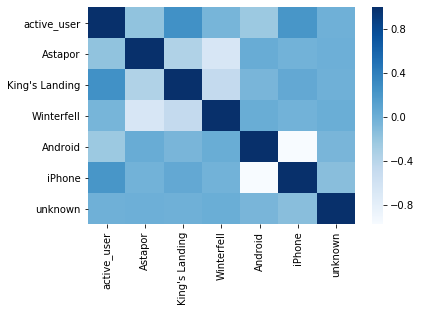

In [47]:
corr2 = df_riders[['active_user', 'Astapor', "King's Landing", 'Winterfell', 'Android', 'iPhone', 'unknown']].corr()

sns.heatmap(corr2, cmap='Blues')
plt.show()

Looks like users from the city of King's Landing and those who use the iPhone platform are most likely to be retained. 

## Modeling

In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve


In [49]:
X = df_riders.drop(['active_user', 'city', 'phone', 'last_trip_date'], axis=1)
y = df_riders.active_user

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

First we will try out a few classification algorithms to see which one performs best on our data. 

In [50]:
clf_xgb = xgb.XGBClassifier()
clf_lr = LogisticRegression()
clf_knn = KNeighborsClassifier()
clf_rf = RandomForestClassifier()

clfs = [clf_xgb, clf_lr, clf_knn, clf_rf]


In [51]:
def classifier_score(clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_pred, y_test)
    precision = precision_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    
    print(clf, 'accuracy:', accuracy, 'precision:', precision, 'recall:', recall, 'f1_score:', f1)



In [52]:
for clf in clfs:
    classifier_score(clf)
    

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1) accuracy: 0.78296 precision: 0.668936170212766 recall: 0.7309927923738665 f1_score: 0.6985890456615932


C:\Users\woody\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) accuracy: 0.71704 precision: 0.504468085106383 recall: 0.6624755518301202 f1_score: 0.5727744896726658
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform') accuracy: 0.724 precision: 0.5893617021276596 recall: 0.6456876456876457 f1_score: 0.6162402669632926


C:\Users\woody\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) accuracy: 0.7568 precision: 0.5976595744680852 recall: 0.7097018696311268 f1_score: 0.6488796488796489


Out of these four algorithms untuned, XGBoost scored the highest overall. Later we will further tune an XGBoost model for optimized accuracy. First we'll examine the feature importances of the Random Forest and XGBoost models to see what categories may be most import for rider retention. 

In [53]:
def feature_importance_plot(clf):
    features = pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
    features.iplot(kind='barh', title='%s feature_importances' %(clf))
    
feature_importance_plot(clf_rf)

In [54]:
feature_importance_plot(clf_xgb)

In [55]:
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf_xgb,
                    parameters, 
                    scoring="neg_log_loss",
                    cv=3, verbose=1)

grid.fit(X_train, y_train)

Fitting 3 folds for each of 3840 candidates, totalling 11520 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 11520 out of 11520 | elapsed: 486.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_l...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
                         'eta': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                         'gamma': [0.0

In [56]:
xgb_tuned = grid.best_estimator_
grid.best_params_

{'colsample_bytree': 0.7,
 'eta': 0.05,
 'gamma': 0.4,
 'max_depth': 6,
 'min_child_weight': 7}

In [57]:
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.05, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=7, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [73]:
xgb_tuned.score(X_train, y_train)

0.8116533333333333

In [68]:
y_pred = xgb_tuned.predict(X_test)
accuracy_score(y_pred, y_test)

0.78704

In [69]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
    
print('accuracy:', accuracy, 'precision:', precision, 'recall:', recall, 'f1_score:', f1, 'roc_auc_score:', roc_auc)

accuracy: 0.78704 precision: 0.6717021276595745 recall: 0.7383068288119738 f1_score: 0.7034313725490197 roc_auc_score: 0.7753426167406172


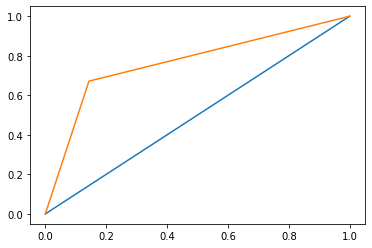

In [71]:
fpr, tpr, thresholds  = roc_curve(y_test, y_pred)

plt.plot([0,1], [0,1])
plt.plot(fpr, tpr)
plt.show()

In [72]:
feature_importance_plot(xgb_tuned)

This model had high accuracy metrics, but seems to be slightly overfit. We'll try playing with the parameters a bit to fix this.

In [62]:
xgb_tuned2 = xgb.XGBClassifier(colsample_bytree=0.5, eta=0.05, gamma=0.3, max_depth=3, min_child_weight=0.5)

xgb_tuned2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.05, gamma=0.3,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=0.5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [63]:
xgb_tuned2.score(X_train, y_train)

0.7898933333333333

In [64]:
xgb_tuned2.score(X_test, y_test)

0.78368

In [65]:
y_pred = xgb_tuned2.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
recall = recall_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
    
print('accuracy:', accuracy, 'precision:', precision, 'recall:', recall, 'f1_score:', f1, 'roc_auc_score:', roc_auc)

accuracy: 0.78368 precision: 0.6631914893617021 recall: 0.7354884379424257 f1_score: 0.6974714701275453 roc_auc_score: 0.7719441705567853


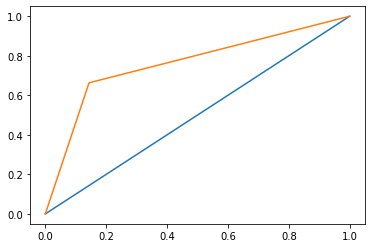

In [66]:
fpr, tpr, thresholds  = roc_curve(y_test, y_pred)

plt.plot([0,1], [0,1])
plt.plot(fpr, tpr)
plt.show()

In [67]:
feature_importance_plot(xgb_tuned2)

This model has high accuracy metrics and is not overfitting. From the feature importances, I would suggest that Ultimate increase marketing campaigns in the cities of Astapor and Winterfell, as the platform does not seem to have achieved as much traction in those markets. The weekday_pct and surge_pct are highly correlated with rider retention, so it would be a good idea to do further tests in those areas. I would also suggest a campaign promoting Ultimate Black, as users with this feature are more likely to remain active.